# Importing Libraries

In [ ]:

#Libraries 
import csv #Read CSVs 
import pandas as pd 
import numpy as np

#Importing ML Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics #auc, roc, and other scores
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score


#Libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Other libraries
import random
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE # BALANCING the data


IMPORT DATASETS

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
#change directory
%cd /content/drive/My Drive/Colab Notebooks/575 Project

#Read csv and convert to pandas dataframe
train_DF = pd.read_csv('bankruptcy_Train.csv', header = 0)
test_DF = pd.read_csv('bankruptcy_Test_X.csv', header = 0)


#Get the total number of Rows and Columns for each DF
print(train_DF.shape)
print(test_DF.shape)


/content/drive/My Drive/Colab Notebooks/575 Project
(10000, 65)
(5000, 65)


### BASELINE MODEL

% of Companies that went Bankrupt : 2.0 %
% of Companies that did not went Bankrupt : 98.0 %


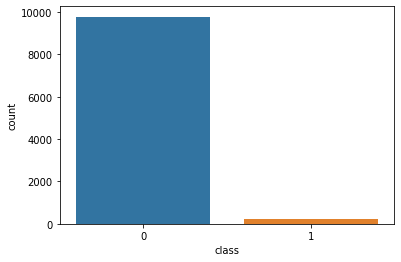

In [ ]:
sns.countplot('class',data=train_DF)

## BASELINE 

bankrupt = train_DF['class'].value_counts()

rate_bankrupt = round(bankrupt[1]/len(train_DF),2)
print("% of Companies that went Bankrupt :", rate_bankrupt*100,"%")

rate_non_bankrupt = round(bankrupt[0]/len(train_DF),2)
print("% of Companies that did not went Bankrupt :", rate_non_bankrupt*100,"%")


### **DATA PRE PROCESSING**

In [ ]:
def check_na(DF):
  for col in DF.columns:
    if len(DF[DF[col].isna()]) >0:
      print(col)
    
check_na(train_DF)

In [ ]:
check_na(test_DF)

In [ ]:
test_DF.describe()

,ID,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,-0.005733,0.007330,-0.000818,-0.005996,0.007083,-0.003084,0.007197,0.010881,0.004458,-0.007591,0.004538,0.003369,-0.001030,0.0072,0.001055,0.003734,0.011851,0.007906,-0.000978,-0.011179,0.013422,0.009044,-0.001165,0.008538,-0.008583,0.004973,0.000782,-0.011127,-0.016554,-0.008122,-0.001649,0.027198,0.001921,0.014881,0.006940,-0.001344,-0.013249,-0.007544,-0.007648,-0.007851,-0.006537,-0.001272,-0.007825,-0.006465,0.00748,-0.011742,0.025162,0.006714,0.002593,0.009605,0.003373,0.027755,0.006284,-0.011009,0.014361,0.009678,0.014961,-0.009707,-0.016201,0.001093,0.006445,-0.009829,0.001204,-0.006362
std,1443.520003,0.216805,0.101846,0.990087,0.556211,0.163345,0.247935,0.040299,0.944216,0.810988,0.128414,0.739170,0.469151,0.764095,0.0403,0.764019,0.951936,0.974497,0.212896,1.140861,0.151683,1.754203,0.723886,1.142581,0.412991,0.382849,0.953209,0.647031,0.065745,0.997709,0.362205,1.209560,1.935707,0.901053,0.970572,0.861529,0.919006,0.362036,0.072078,1.473247,0.473741,0.037637,1.193166,0.323507,0.324629,0.12517,0.452920,1.606498,0.799811,1.102724,1.044568,0.955541,1.939835,1.127371,0.062193,1.130408,0.028385,0.593384,0.028647,0.100155,0.776294,0.967076,0.088811,0.863946,0.426877
min,1.000000,-3.133300,-0.167400,-10.772800,-0.379600,-7.782200,-1.263700,-0.537900,-0.979100,-1.290700,-3.255500,-10.142000,-2.040600,-3.413800,-0.5379,-17.966300,-5.038900,-1.007100,-0.531800,-80.244700,-0.073700,-0.020000,-6.575600,-80.387500,-0.989200,-8.061600,-3.958300,-0.078700,-0.623800,-6.376200,-0.187900,-85.035600,-0.032500,-0.765000,-1.910300,-11.345400,-1.494500,-0.034700,-0.953300,-103.812800,-0.293100,-0.081300,-80.980300,-0.032800,-0.022700,-5.35950,-0.332400,-0.043900,-13.531100,-77.555100,-0.972100,-1.536500,-0.031600,-11.938100,-0.638200,-5.926800,-1.988400,-13.514800,-0.028900,-3.141000,-0.048600,-0.413000,-0.022100,-0.743300,-0.051000
25%,1250.750000,-0.078900,-0.056725,-0.524425,-0.193200,0.006800,-0.016000,-0.007900,-0.450225,-0.386425,-0.071425,-0.305025,-0.160725,-0.012200,-0.0079,-0.020600,-0.425625,-0.450825,-0.009900,0.001600,-0.050600,-0.016200,-0.337050,0.004500,-0.038725,-0.183225,-0.409025,-0.010000,-0.021100,-0.650100,-0.023200,-0.001500,-0.024300,-0.379500,-0.617925,-0.366550,-0.593100,-0.034400,-0.044900,-0.011500,-0.137200,-0.007400,-0.009200,-0.020500,-0.016200,0.00380,-0.185300,-0.035100,-0.224200,0.005800,-0.477700,-0.663325,-0.023700,-0.029200,-0.020800,-0.127200,0.009300,0.003200,-0.010800,-0.022800,-0.043500,-0.221325,-0.016900,-0.373400,-0.041500
50%,2500.500000,-0.019150,-0.001500,0.009700,-0.118250,0.007300,-0.016000,0.004150,-0.250750,-0.305750,0.003050,-0.047850,-0.094300,-0.011300,0.0042,-0.012100,-0.243850,-0.253250,0.002000,0.016600,-0.028900,-0.015700,-0.068300,0.017600,-0.004500,0.026200,-

In [ ]:
#train_DF.head(10)
## Computing the descriptive statistic of our data
## Attributes are all ratios and numericals

train_DF.describe()


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.009157,0.006348,0.010863,0.008542,0.008754,-0.003778,0.006704,-0.000856,-0.010930,-0.006547,-0.004247,0.003580,-0.000114,0.006702,-0.006597,-0.010008,-0.000586,0.005903,-0.004566,0.012655,-0.002667,-0.003858,-0.004656,-0.001327,-0.004913,-0.009995,0.004353,-0.005976,0.000169,0.010593,-0.004370,-0.006619,0.001813,-0.006228,-0.004552,-0.014016,-0.001665,-0.006565,0.000222,0.008269,0.006924,-0.004904,0.009633,0.008136,-0.007019,0.011167,-0.003063,-0.004120,-0.007716,-0.003003,-0.012968,-0.007065,-0.005346,-0.006170,-0.009852,-0.009801,-0.013509,0.009847,0.014134,0.001855,-0.010073,0.009683,0.001845,0.000212,0.021500
std,0.215420,0.094827,0.968869,1.289251,0.143395,0.619168,0.038732,1.079138,1.006380,0.119024,0.709514,1.044094,1.147029,0.038731,0.886776,0.962177,1.065365,0.149013,1.144668,1.407831,0.597995,0.690847,1.144789,1.305798,0.368498,0.968603,1.336851,0.357369,0.995939,1.388583,1.107125,0.347134,1.142186,1.046148,0.792318,0.908651,0.597916,0.069757,0.927413,1.285829,1.412783,1.089262,1.393747,1.393610,1.410064,1.304679,0.839406,0.755790,1.151445,0.957153,0.925995,0.335484,0.665519,0.352126,1.027218,1.412866,1.330633,1.412864,1.405636,1.251921,1.056577,1.410930,1.162661,0.990925,0.145051
min,-5.317200,-0.170000,-12.170600,-0.381600,-1.111400,-22.442600,-0.399800,-1.039100,-1.296400,-3.300800,-7.625700,-10.286100,-4.252600,-0.399800,-64.255900,-7.243200,-1.026900,-0.395800,-98.844200,-0.073700,-0.020100,-7.407700,-99.021100,-89.689400,-8.422100,-7.834400,-1.090700,-2.388900,-7.035400,-0.080600,-92.356000,-0.032500,-0.765200,-2.415500,-11.345400,-1.497700,-0.035800,-0.853400,-86.746700,-2.558900,-0.366500,-91.709800,-0.032900,-0.022800,-140.725100,-1.970900,-0.044000,-15.537200,-86.866500,-0.976300,-1.565000,-0.031800,-16.155000,-2.443000,-19.008000,-117.531300,-118.282900,-0.024200,-4.816200,-0.048600,-0.413100,-0.022200,-0.743300,-0.051000,0.000000
25%,-0.079625,-0.055000,-0.516700,-0.192300,0.006800,-0.016000,-0.008000,-0.442525,-0.389500,-0.067000,-0.308850,-0.161700,-0.012200,-0.008000,-0.020200,-0.427850,-0.441150,-0.010000,0.001400,-0.050125,-0.016200,-0.341725,0.004400,-0.040000,-0.170725,-0.412550,-0.010000,-0.021100,-0.636375,-0.023000,-0.001700,-0.024200,-0.383100,-0.618500,-0.363625,-0.594950,-0.034400,-0.045000,-0.011700,-0.137900,-0.007400,-0.009600,-0.020300,-0.016100,0.003800,-0.184625,-0.034800,-0.224725,0.006075,-0.475900,-0.670425,-0.023600,-0.029100,-0.020700,-0.127200,0.009300,0.003200,-0.010800,-0.022700,-0.043400,-0.223400,-0.016800,-0.370700,-0.041500,0.000000
50%,-0.021300,-0.000050,0.005600,-0.118150,0.007300,-0.016000,0.003800,-0.261950,-0.311100,0.000200,-0.058850,-0.098000,-0.011300,0.003850,-0.011500,-0.248100,-0.259

# **Missing Values**

NA Ratio %s for all columns in Train:
class     0.0
Attr32    0.0
Attr30    0.0
Attr29    0.0
Attr28    0.0
         ... 
Attr38    0.0
Attr37    0.0
Attr36    0.0
Attr35    0.0
Attr1     0.0
Length: 65, dtype: float64


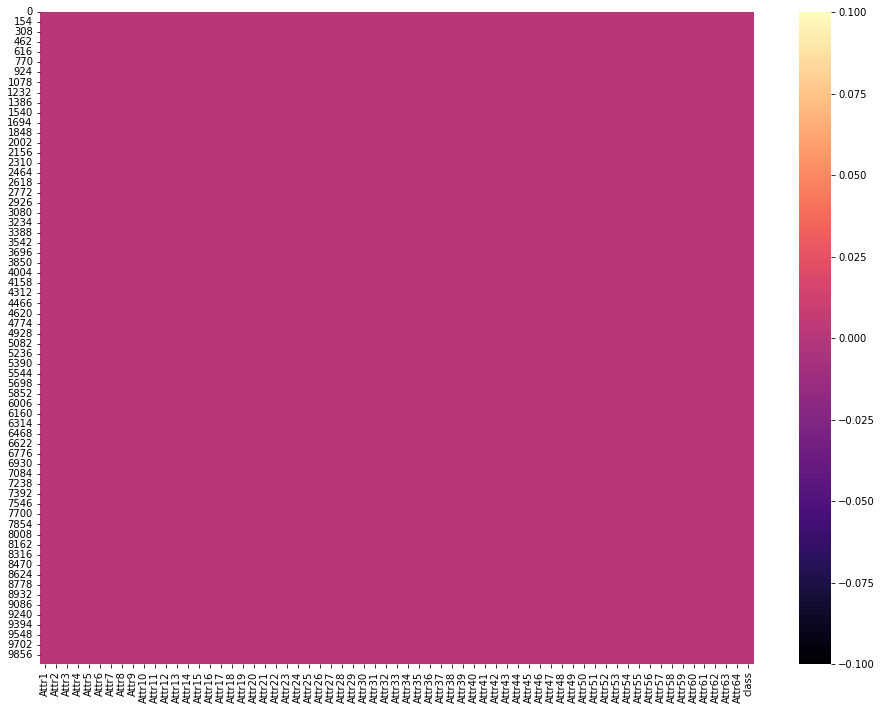

In [ ]:
#Check for Missing Values
plt.figure(figsize=(16,12)) 
sns.heatmap(train_DF.isnull(), cmap = 'magma')

#NO MISSING VALUES in the given data set
#Calcuate missing values % for each column
na_ratio_train = train_DF.isna().sum().sort_values(ascending = False)/len(train_DF)
print("NA Ratio %s for all columns in Train:")
print(na_ratio_train)

# **Check for NULL Values**

In [ ]:
#check for NAs
train_DF.isna().sum().max()
[print(col) for col in train_DF if train_DF[col].isna().sum() > 0]


[]

In [ ]:
print(train_DF.shape)

(10000, 65)


# **Dropping the duplicates**

In [ ]:
newtrain_DF = train_DF.drop_duplicates()

# newtrain_DF = train_DF.drop_duplicates().shape[0]
# print(newtrain_DF)

type(newtrain_DF)
print(newtrain_DF.shape)

(9944, 65)


In [ ]:
newtrain_DF.isna().sum().max()
[print(col) for col in newtrain_DF if newtrain_DF[col].isna().sum() > 0]


[]

# **Multicollinearity-Check**

Check if there is perfect correlation between any of the columns. If the correlation is more than 0.95 or less than -0.95 then we would remove one of the columns to avoid multicollinearity in the data-set

In [ ]:
corr_mat = newtrain_DF.corr()
corr_mat = corr_mat.iloc[1:,1:]

drop_list = []
for i in range(len(corr_mat.columns)):
    for j in range(i):
        if(corr_mat.iloc[i,j] >= 0.7 or corr_mat.iloc[i,j] <= -0.7):
            if corr_mat.columns[j] not in drop_list:
                drop_list.append(corr_mat.columns[j])
  
len(drop_list)

33

In [ ]:
drop_list

['Attr2',
 'Attr7',
 'Attr4',
 'Attr11',
 'Attr8',
 'Attr13',
 'Attr14',
 'Attr19',
 'Attr10',
 'Attr16',
 'Attr23',
 'Attr22',
 'Attr31',
 'Attr12',
 'Attr39',
 'Attr30',
 'Attr43',
 'Attr40',
 'Attr32',
 'Attr42',
 'Attr17',
 'Attr38',
 'Attr47',
 'Attr28',
 'Attr53',
 'Attr20',
 'Attr56',
 'Attr57',
 'Attr45',
 'Attr44',
 'Attr33',
 'Attr46',
 'Attr54']

In [ ]:
Final_DF = newtrain_DF.drop(['Attr2',
 'Attr7',
 'Attr4',
 'Attr11',
 'Attr8',
 'Attr13',
 'Attr14',
 'Attr19',
 'Attr10',
 'Attr16',
 'Attr23',
 'Attr22',
 'Attr31',
 'Attr12',
 'Attr39',
 'Attr30',
 'Attr43',
 'Attr40',
 'Attr32',
 'Attr42',
 'Attr17',
 'Attr38',
 'Attr47',
 'Attr28',
 'Attr53',
 'Attr20',
 'Attr56',
 'Attr57',
 'Attr45',
 'Attr44',
 'Attr33',
 'Attr46',
 'Attr54'], axis =1)
print(Final_DF.shape)

## After Multi collinearity check we have some columns eliminated

(9944, 32)


# Data Description

Data Description - Interpreting Data Description The results show 8 numbers for each column in your original dataset. The first number, the count, shows how many rows have non-missing values.

Missing values arise for many reasons. For example, the size of the 2nd bedroom wouldn't be collected when surveying a 1 bedroom house.

The second value is the mean, which is the average. Under that, std is the standard deviation, which measures how numerically spread out the values are.

To interpret the min, 25%, 50%, 75% and max values, imagine sorting each column from lowest to highest value. The first (smallest) value is the min. If you go a quarter way through the list, you'll find a number that is bigger than 25% of the values and smaller than 75% of the values. That is the 25% value (pronounced "25th percentile"). The 50th and 75th percentiles are defined analogously, and the max is the largest number.



In [ ]:
Final_DF.describe()


,Attr1,Attr3,Attr5,Attr6,Attr9,Attr15,Attr18,Attr21,Attr24,Attr25,Attr26,Attr27,Attr29,Attr34,Attr35,Attr36,Attr37,Attr41,Attr48,Attr49,Attr50,Attr51,Attr52,Attr55,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000
mean,-0.009037,0.011330,0.008764,-0.003803,-0.010195,-0.006605,0.005934,-0.002594,-0.001326,-0.005311,-0.010714,0.004433,-0.001791,-0.006689,-0.004583,-0.012988,-0.001545,0.007004,-0.003968,-0.007899,-0.004904,-0.013419,-0.007032,-0.009710,0.009960,0.014311,0.002085,-0.009270,0.009789,0.002075,0.000379,0.021420
std,0.215385,0.967817,0.143798,0.620898,1.008270,0.889233,0.149401,0.599676,1.309457,0.368908,0.965267,1.340610,0.996418,1.045613,0.791766,0.909600,0.599592,1.416756,0.756477,1.154655,0.951010,0.924906,0.336425,1.028440,1.416836,1.409586,1.255438,1.059451,1.414896,1.163934,0.993708,0.144787
min,-5.317200,-12.170600,-1.111400,-22.442600,-1.296400,-64.255900,-0.395800,-0.020100,-89.689400,-8.422100,-7.834400,-1.090700,-7.035400,-2.415500,-11.345400,-1.497700,-0.035800,-0.366500,-15.537200,-86.866500,-0.976300,-1.565000,-0.031800,-19.008000,-0.024200,-4.816200,-0.048600,-0.413100,-0.022200,-0.743300,-0.051000,0.000000
25%,-0.079600,-0.516300,0.006800,-0.016000,-0.389300,-0.020200,-0.010000,-0.016200,-0.040000,-0.171175,-0.412500,-0.010000,-0.639250,-0.618225,-0.363425,-0.593725,-0.034400,-0.007400,-0.224700,0.006100,-0.476100,-0.670175,-0.023600,-0.127200,-0.010800,-0.022700,-0.043400,-0.223300,-0.016800,-0.370150,-0.041500,0.000000
50%,-0.021200,0.005600,0.007300,-0.016000,-0.310550,-0.011500,0.001700,-0.015700,-0.005600,0.026650,-0.236050,-0.009900,-0.042000,-0.314350,-0.081450,-0.204700,-0.033800,-0.007400,-0.001050,0.024700,-0.229500,-0.160650,-0.019100,-0.101300,-0.009900,-0.020400,-0.040000,-0.141000,-0.013700,-0.186950,-0.034400,0.000000
75%,0.076325,0.602500,0.007800,0.015825,0.132850,0.005500,0.021000,-0.015100,0.043300,0.215825,0.099150,-0.009900,0.603425,0.288025,0.336225,0.331300,-0.031100,-0.007300,0.289650,0.047100,0.138400,0.483675,-0.012600,-0.020875,-0.009400,-0.014300,-0.032100,-0.008050,-0.009500,0.119825,-0.021000,0.000000
max,2.337300,3.332500,11.556200,54.566700,62.936400,34.847100,14.409500,39.113500,87.817000,0.666600,23.238100,133.595200,4.638200,29.360100,8.318300,9.078800,36.464800,141.269000,6.655200,1.330000,21.293200,11.640300,21.992900,74.119500,117.517700,128.352800,117.341100,59.139200,136.430900,62.527200,90.774700,1.000000


***Due to Multicolinearity, 19 columns have been dropped from the training dataset***



In [ ]:
print(Final_DF.shape)
(Final_DF.columns)

(9944, 32)


Index(['Attr1', 'Attr3', 'Attr5', 'Attr6', 'Attr9', 'Attr15', 'Attr18',
       'Attr21', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr29', 'Attr34',
       'Attr35', 'Attr36', 'Attr37', 'Attr41', 'Attr48', 'Attr49', 'Attr50',
       'Attr51', 'Attr52', 'Attr55', 'Attr58', 'Attr59', 'Attr60', 'Attr61',
       'Attr62', 'Attr63', 'Attr64', 'class'],
      dtype='object')

# **Histograms - to check the distribution of data**

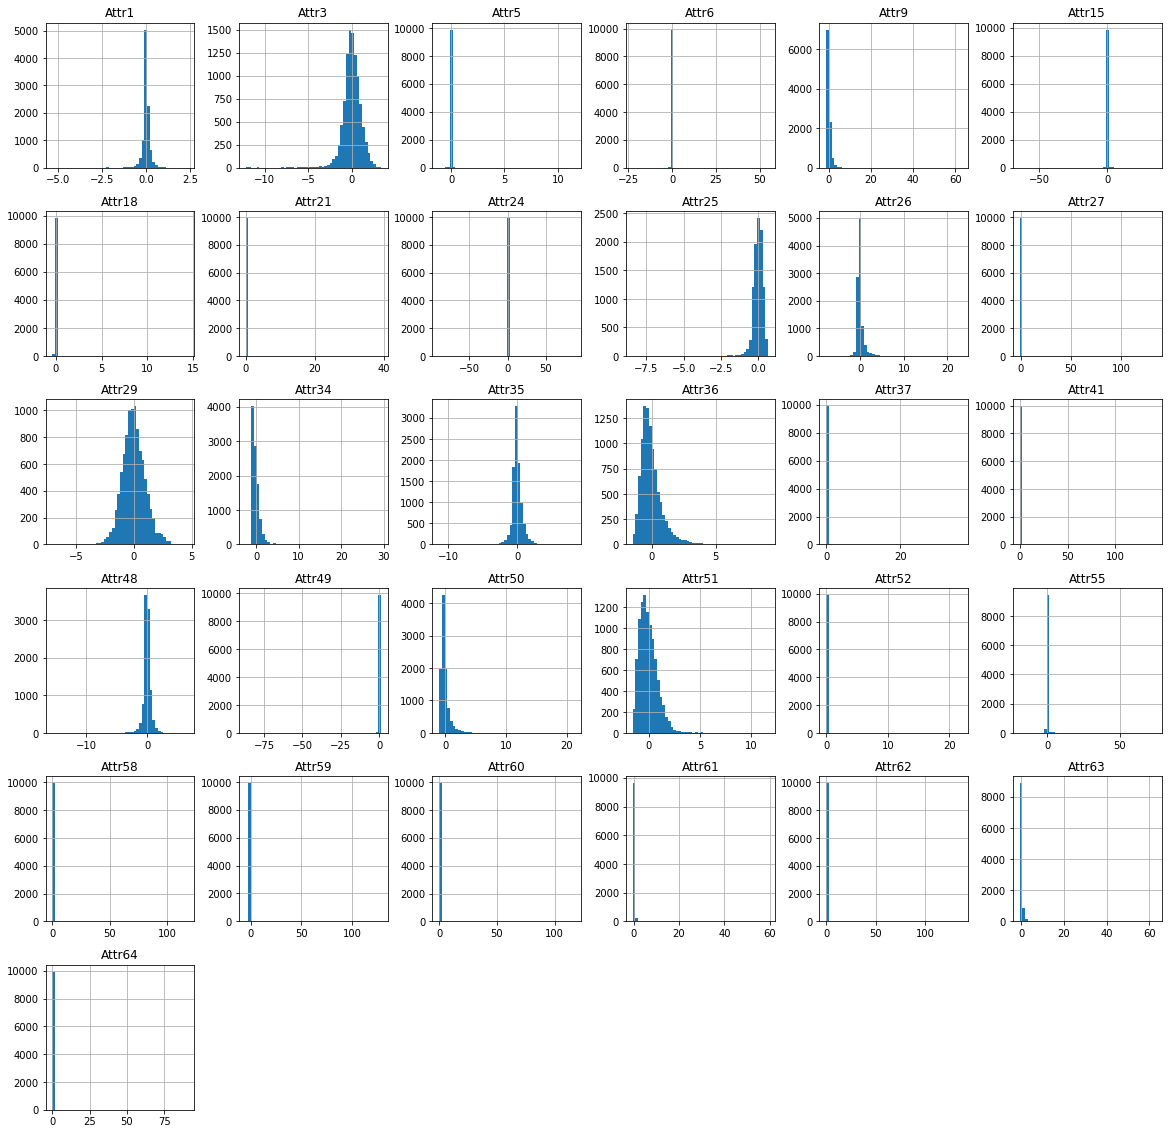

In [ ]:
Final_DF1 = Final_DF.drop("class", axis=1)
Final_DF1.hist(bins = 50, figsize= (20,20))
plt.show()

#  EDA & VISUALIZATIONS

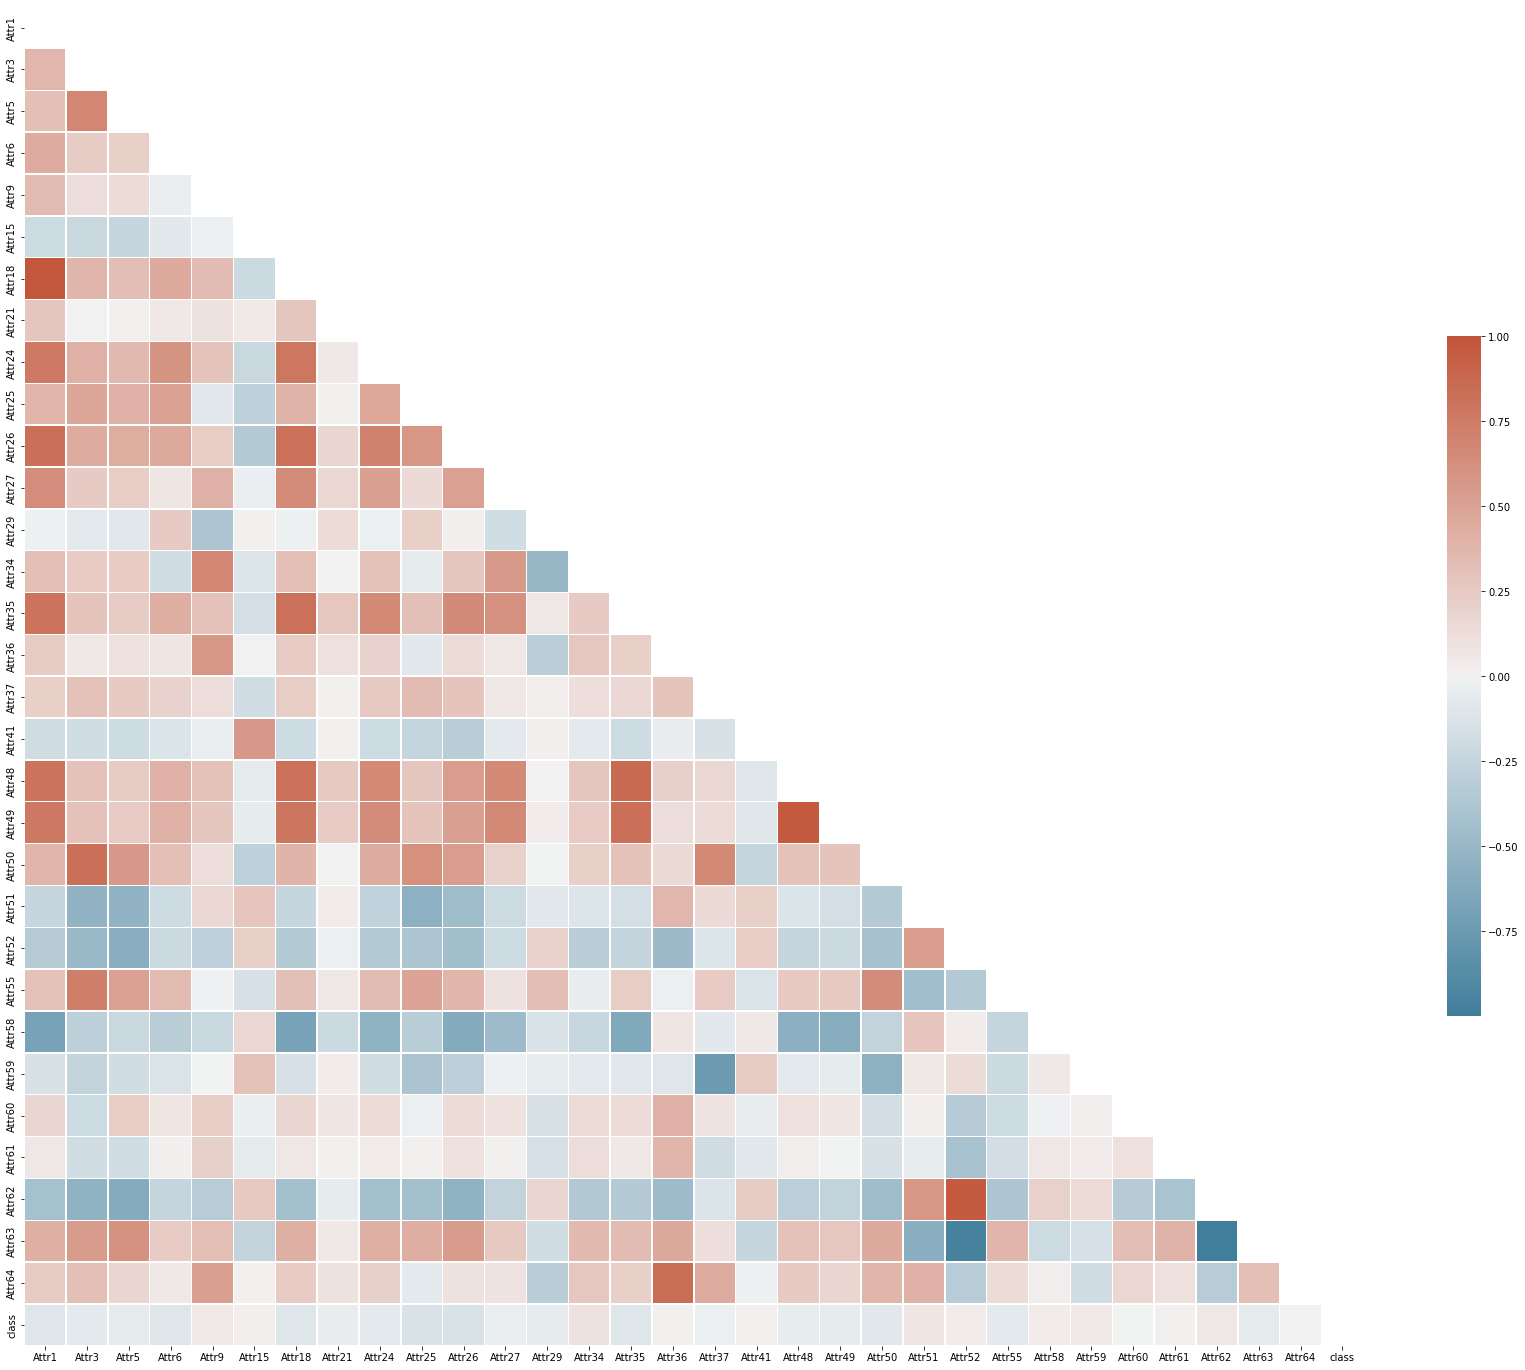

In [ ]:
# Correlation Heatmap (Spearman)

f, ax = plt.subplots(figsize=(30, 25))
mat = Final_DF.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Getting the Training & Test Datasets with 80% training data

In [ ]:
print(Final_DF.shape)

(9944, 32)


In [ ]:
Final_DF.describe()

,Attr1,Attr3,Attr5,Attr6,Attr9,Attr15,Attr18,Attr21,Attr24,Attr25,Attr26,Attr27,Attr29,Attr34,Attr35,Attr36,Attr37,Attr41,Attr48,Attr49,Attr50,Attr51,Attr52,Attr55,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000,9944.000000
mean,-0.009037,0.011330,0.008764,-0.003803,-0.010195,-0.006605,0.005934,-0.002594,-0.001326,-0.005311,-0.010714,0.004433,-0.001791,-0.006689,-0.004583,-0.012988,-0.001545,0.007004,-0.003968,-0.007899,-0.004904,-0.013419,-0.007032,-0.009710,0.009960,0.014311,0.002085,-0.009270,0.009789,0.002075,0.000379,0.021420
std,0.215385,0.967817,0.143798,0.620898,1.008270,0.889233,0.149401,0.599676,1.309457,0.368908,0.965267,1.340610,0.996418,1.045613,0.791766,0.909600,0.599592,1.416756,0.756477,1.154655,0.951010,0.924906,0.336425,1.028440,1.416836,1.409586,1.255438,1.059451,1.414896,1.163934,0.993708,0.144787
min,-5.317200,-12.170600,-1.111400,-22.442600,-1.296400,-64.255900,-0.395800,-0.020100,-89.689400,-8.422100,-7.834400,-1.090700,-7.035400,-2.415500,-11.345400,-1.497700,-0.035800,-0.366500,-15.537200,-86.866500,-0.976300,-1.565000,-0.031800,-19.008000,-0.024200,-4.816200,-0.048600,-0.413100,-0.022200,-0.743300,-0.051000,0.000000
25%,-0.079600,-0.516300,0.006800,-0.016000,-0.389300,-0.020200,-0.010000,-0.016200,-0.040000,-0.171175,-0.412500,-0.010000,-0.639250,-0.618225,-0.363425,-0.593725,-0.034400,-0.007400,-0.224700,0.006100,-0.476100,-0.670175,-0.023600,-0.127200,-0.010800,-0.022700,-0.043400,-0.223300,-0.016800,-0.370150,-0.041500,0.000000
50%,-0.021200,0.005600,0.007300,-0.016000,-0.310550,-0.011500,0.001700,-0.015700,-0.005600,0.026650,-0.236050,-0.009900,-0.042000,-0.314350,-0.081450,-0.204700,-0.033800,-0.007400,-0.001050,0.024700,-0.229500,-0.160650,-0.019100,-0.101300,-0.009900,-0.020400,-0.040000,-0.141000,-0.013700,-0.186950,-0.034400,0.000000
75%,0.076325,0.602500,0.007800,0.015825,0.132850,0.005500,0.021000,-0.015100,0.043300,0.215825,0.099150,-0.009900,0.603425,0.288025,0.336225,0.331300,-0.031100,-0.007300,0.289650,0.047100,0.138400,0.483675,-0.012600,-0.020875,-0.009400,-0.014300,-0.032100,-0.008050,-0.009500,0.119825,-0.021000,0.000000
max,2.337300,3.332500,11.556200,54.566700,62.936400,34.847100,14.409500,39.113500,87.817000,0.666600,23.238100,133.595200,4.638200,29.360100,8.318300,9.078800,36.464800,141.269000,6.655200,1.330000,21.293200,11.640300,21.992900,74.119500,117.517700,128.352800,117.341100,59.139200,136.430900,62.527200,90.774700,1.000000


In [ ]:
# Data split
X=Final_DF.drop(labels=['class'], axis=1)
y=Final_DF['class']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0,stratify = y)

print("Shape of X Training data", X_train.shape)
print("Shape of y Training data" ,y_train.shape)

print("Shape of X Test data", X_test.shape)
print("Shape of y Test data" ,y_test.shape)

print(y_train)
print(y_test)

Shape of X Training data (7955, 31)
Shape of y Training data (7955,)
Shape of X Test data (1989, 31)
Shape of y Test data (1989,)
8540    0
3829    0
2168    0
963     0
7450    0
       ..
7129    0
2323    0
4676    0
739     0
3514    0
Name: class, Length: 7955, dtype: int64
1650    0
7741    0
2718    0
3287    0
4427    0
       ..
2917    0
3257    0
3976    0
3023    0
759     0
Name: class, Length: 1989, dtype: int64


# Balancing the labels - for training data

*The data is highly imbalanced and we will have to balance the data*

In [ ]:
# print(X_train)
# print(y_train)

X_train.isna().sum().max()
[print(col) for col in X_train if X_train[col].isna().sum() > 0]


[]

In [ ]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train,y_train)

print(X_sm.shape)
print(y_sm.shape)

(15570, 31)
(15570,)


Shape of Y after balancing (15570, 31)
Shape of Y after balancing (15570, 1)


Text(0.5, 1.0, 'Balanced Train Dataset')

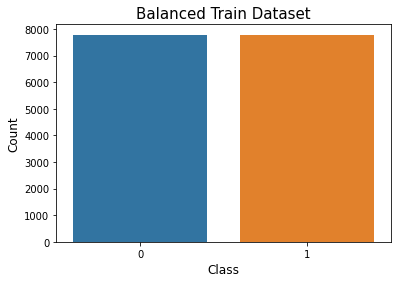

In [ ]:
## convert the numpy arry into dataframe
train_balanced_DF_X = pd.DataFrame(X_sm,columns = ['Attr1', 'Attr3', 'Attr5', 'Attr6', 'Attr9', 'Attr15', 'Attr18',
       'Attr21', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr29', 'Attr34',
       'Attr35', 'Attr36', 'Attr37', 'Attr41', 'Attr48', 'Attr49', 'Attr50',
       'Attr51', 'Attr52', 'Attr55', 'Attr58', 'Attr59', 'Attr60', 'Attr61',
       'Attr62', 'Attr63', 'Attr64'])
train_balanced_DF_Y = pd.DataFrame(y_sm,columns=["class"])

print("Shape of Y after balancing", train_balanced_DF_X.shape)
print("Shape of Y after balancing" ,train_balanced_DF_Y.shape)

#print(train_balanced_DF_Y)

sns.countplot('class',data=train_balanced_DF_Y)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Balanced Train Dataset", fontsize=15)

**Data Normazlization for better model**

In [ ]:
#Data Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(train_balanced_DF_X)
X_test = scaler.transform(X_test)

Now we have the training data as X_train

# **Getting the Training & Validation Data set from X_train & y_train**

In [ ]:
# Split into validation and training data
trn_X, val_X, trn_y, val_y = train_test_split(X_train, train_balanced_DF_Y, random_state=0)

print("Shape of X Training data", trn_X.shape)
print("Shape of y Training data" ,trn_y.shape)

print("Shape of X Validation data", val_X.shape)
print("Shape of y Validation data" ,val_y.shape)



Shape of X Training data (11677, 31)
Shape of y Training data (11677, 1)
Shape of X Validation data (3893, 31)
Shape of y Validation data (3893, 1)


# Decision Tree Model - Basic

In [ ]:
# Function to find the best MAE 
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)


candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
# loop to find the ideal tree size from candidate_max_leaf_nodes
mae_best = {}
for i in candidate_max_leaf_nodes:
    mae_i = get_mae(i,trn_X, val_X, trn_y, val_y)
    mae_best[i]=mae_i

best = min(mae_best.items(), key=lambda x: x[1])

# the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500) and this is stored in best_tree_size
best_tree_size = best[0]
print(best_tree_size)
# Final Model with optimal size
final_modelDT = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=0)

#fit the final model and find the MAE final on given test data
final_modelDT.fit(X_train,train_balanced_DF_Y)
pred_DT = final_modelDT.predict(X_test)
mae = mean_absolute_error(y_test, pred_DT)

## pred_DT are continuous values and we convert them into binary by using pred_DT>0.5
print(round(mae,2))

500
0.06


In [ ]:
print('Decision Tree:')
print('Accuracy score:', round(accuracy_score(y_test, pred_DT >0.5) * 100, 2))
print('F1 score:', round(f1_score(y_test, pred_DT>0.5) * 100, 2))

Decision Tree:
Accuracy score: 93.67
F1 score: 19.23


# ROC PR curve Function

In [ ]:
# PR Curve

def doLogisticRegression(x, y):
  # Instanciate an object from Logistic Regression class.
  lr = LogisticRegression()
  # training and prediction
  lr.fit(x, y)
  y_pred = lr.predict(x)

  # Return training accuracy and confusion matrix
  return accuracy_score(y, y_pred), confusion_matrix(y, y_pred), lr

def drawPRandRoc(x_train_smote, y_train_smote, X_test_norm, y_test):
  figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (9,3))
  trainAcc, trainConf, LR = doLogisticRegression(x_train_smote, y_train_smote)
  y_test_pred = LR.predict(X_test_norm)
  y_test_pred_prob = LR.predict_proba(X_test_norm)[:, 1]
       
  # Draw a precision-recall curve.
  precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_pred_prob)
  avg_pre = average_precision_score(y_test, y_test_pred_prob)
  ax1.plot(precision, recall, label = " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
  ax1.set_xlabel('Precision', fontsize = 14)
  ax1.set_ylabel('Recall', fontsize = 14)
  ax1.set_title('Precision-Recall Curve', fontsize = 18)
  ax1.legend(loc = 'best')
  
  # Find the default threshold
  close_default = np.argmin(np.abs(thresholds_pr - 0.5))
  ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

  # Draw the roc-curve
  fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_prob)
  roc_auc = auc(fpr,tpr)
  ax2.plot(fpr,tpr, label = " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
  ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
  ax2.set_xlabel("False Positive Rate", fontsize = 14)
  ax2.set_ylabel("True Positive Rate", fontsize = 14)
  ax2.set_title("ROC Curve", fontsize = 18)
  ax2.legend(loc = 'best')

  # Find the default threshold
  close_default = np.argmin(np.abs(thresholds_roc - 0.5))
  ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
  plt.tight_layout()

# **Define Confusion Matrix Function**

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='magma',     # cmaps = magma, copper, mako, nipy_spectral
                          title=None):
  
      # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Actual')
        plt.xlabel('Predicted' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


## **Confusion Matrix For Decision Tree**

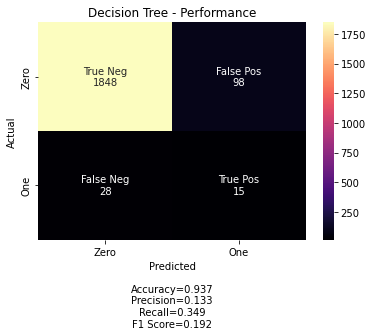

In [ ]:
# Plot Confusion Matrix for decision Tree
model_name = 'Decision Tree'
cm = confusion_matrix(y_test, pred_DT>0.5)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, group_names=labels, categories=categories, percent=False)
plt.title(f'{model_name} - Performance')
print()

# ROC curve & AUC for Decision Tree

In [ ]:
#Print the classification report
print(classification_report(y_test, pred_DT>0.5))

# y_pred_DF = final_modelDT.predict_proba(X_test)[:,1]
DT_fpr, DT_tpr, threshold = roc_curve(y_test, pred_DT>0.5)
auc_DT = auc(DT_fpr, DT_tpr)

print(auc_DT)



              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1946
           1       0.13      0.35      0.19        43

    accuracy                           0.94      1989
   macro avg       0.56      0.65      0.58      1989
weighted avg       0.97      0.94      0.95      1989

0.6492387485360549


# **Hyperparameter Tuning - Grid Search**

In [ ]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','sigmoid']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,20,30,40,50],
            'criterion':['gini','entropy']
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto'),
        'params': {
            'C': [1,5,10],
            'solver':['lbfgs','liblinear']
        }
    },
   'KNN': {
        'model':KNeighborsClassifier(),
        'params':{
            'n_neighbors' : [1,3,5,7],
            'algorithm':['auto','kd_tree']
        }
    }
}


**Implementing Grid Search CV for the models **

In [ ]:

X_scaled = scaler.fit_transform(X_train)

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=3, verbose=3, n_jobs=-1, scoring = 'recall', return_train_score=False)
    clf.fit(X_scaled, train_balanced_DF_Y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 17.2min finished


Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   41.2s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.5s finished


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   35.0s finished


,model,best_score,best_params
0,svm,0.989852,"{'C': 20, 'kernel': 'rbf'}"
1,random_forest,0.997559,"{'criterion': 'entropy', 'n_estimators': 50}"
2,logistic_regression,0.916378,"{'C': 1, 'solver': 'lbfgs'}"
3,KNN,0.999101,"{'algorithm': 'auto', 'n_neighbors': 3}"


# Logistic Regression

In [ ]:
logmodel = LogisticRegression(solver='lbfgs',multi_class='auto', C = 1)
logmodel.fit(X_train, train_balanced_DF_Y)
log_predictions = logmodel.predict(X_test)

# Printing Confusion Matrix
pd.DataFrame(confusion_matrix(y_test,log_predictions))

,0,1
0,1401,545
1,3,40


In [ ]:
#Printing Classification Report
print(classification_report(y_test,log_predictions))

              precision    recall  f1-score   support

           0       1.00      0.72      0.84      1946
           1       0.07      0.93      0.13        43

    accuracy                           0.72      1989
   macro avg       0.53      0.83      0.48      1989
weighted avg       0.98      0.72      0.82      1989



# Confusion Matrix for Logistic Regression

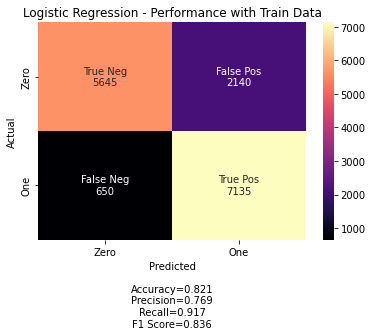

In [ ]:
# Plot Confusion Matrix for LR - Train Data
logmodel1 = LogisticRegression(solver='lbfgs',multi_class='auto', C = 1)
logmodel1.fit(X_train, train_balanced_DF_Y)
log_predictions1 = logmodel1.predict(X_train)
model_name = 'Logistic Regression'
cm1 = confusion_matrix(train_balanced_DF_Y, log_predictions1)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm1, group_names=labels, categories=categories, percent=False)
plt.title(f'{model_name} - Performance with Train Data')
print()

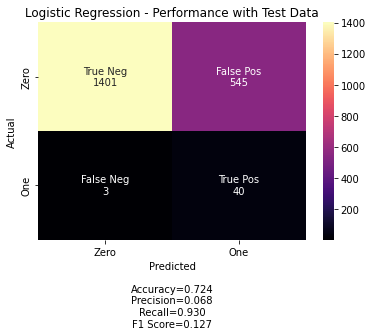

In [ ]:
# Plot Confusion Matrix for LR - Test Data
model_name = 'Logistic Regression'
cm = confusion_matrix(y_test, log_predictions)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, group_names=labels, categories=categories, percent=False)
plt.title(f'{model_name} - Performance with Test Data')
print()

In [ ]:
print('Logistic Regression for Test Data :')
print('Accuracy score:', round(accuracy_score(y_test, log_predictions) * 100, 2))
print('F1 score:', round(f1_score(y_test, log_predictions) * 100, 2))

Logistic Regression for Test Data :
Accuracy score: 72.45
F1 score: 12.74


In [ ]:
# AUC - Logistic Regression

y_pred_logistic = logmodel.predict_proba(X_test)[:,1]
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_logistic)
auc_logistic = auc(logistic_fpr, logistic_tpr)
print(auc_logistic)

0.8888118740887688


# ROC PR curve for Logistic Regression

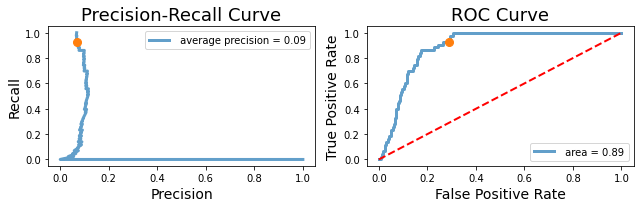

In [ ]:
drawPRandRoc(X_train, train_balanced_DF_Y, X_test, y_test)

# SVM

In [ ]:
model_svm = SVC(gamma='auto',C=20, kernel='rbf', probability=True )
model_svm.fit(X_train,train_balanced_DF_Y)
svm_predictions = model_svm.predict(X_test)

# Printing Confusion Matrix
pd.DataFrame(confusion_matrix(y_test,svm_predictions))

# printing the classification report
print(classification_report(y_test,svm_predictions))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1946
           1       0.10      0.67      0.17        43

    accuracy                           0.86      1989
   macro avg       0.54      0.77      0.55      1989
weighted avg       0.97      0.86      0.91      1989



**ROC & AUC for SVM**

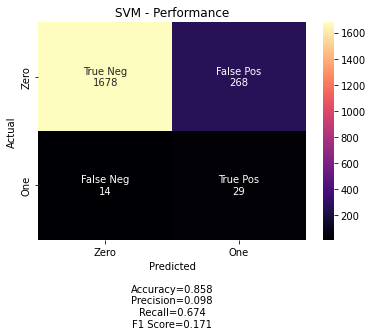

In [ ]:
# Plot Confusion Matrix for SVM
model_name = 'SVM'
cm = confusion_matrix(y_test, svm_predictions)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, group_names=labels, categories=categories, percent=False)
plt.title(f'{model_name} - Performance')
print()

In [ ]:

y_pred_svm = model_svm.predict_proba(X_test)[:,1]
svm_fpr, svm_tpr, threshold = roc_curve(y_test, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)
print(auc_svm)

0.8837687325222878


# KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3,algorithm = 'auto')
knn.fit(X_train,train_balanced_DF_Y)
knn_pred = knn.predict(X_test)

# Printing Confusion Matrix
pd.DataFrame(confusion_matrix(y_test,knn_pred))

# printing the classification report
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1946
           1       0.05      0.26      0.09        43

    accuracy                           0.88      1989
   macro avg       0.52      0.58      0.51      1989
weighted avg       0.96      0.88      0.92      1989



ROC & AUC for KNN

In [ ]:
## Print all values
np.set_printoptions(threshold=np.inf)
print(y_pred_knn)

[0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.33333333 0.
 0.33333333 0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.33333333
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.33333333
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.66666667 0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.    

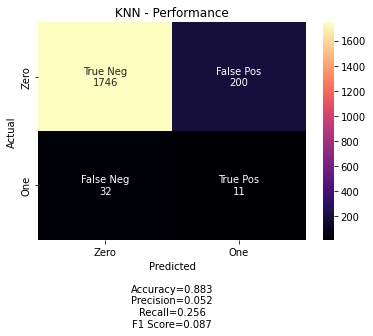

In [ ]:
# Plot Confusion Matrix for KNN
model_name = 'KNN'
cm = confusion_matrix(y_test, y_pred_knn>0.5)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, group_names=labels, categories=categories, percent=False)
plt.title(f'{model_name} - Performance')
print()

In [ ]:
y_pred_knn = knn.predict_proba(X_test)[:,1]
knn_fpr, knn_tpr, threshold = roc_curve(y_test, y_pred_knn)
auc_knn = auc(knn_fpr, knn_tpr)
print(auc_knn)

0.6345813714476924


# Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy' )
rfc.fit(X_train,train_balanced_DF_Y )
rfc_pred = rfc.predict(X_test)

# Printing Confusion Matrix
pd.DataFrame(confusion_matrix(y_test,rfc_pred))

# printing the classification report
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1946
           1       0.31      0.26      0.28        43

    accuracy                           0.97      1989
   macro avg       0.65      0.62      0.63      1989
weighted avg       0.97      0.97      0.97      1989



ROC & AUC for Random Forest

In [ ]:
## Print all values
np.set_printoptions(threshold=np.inf)
print(rfc_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 

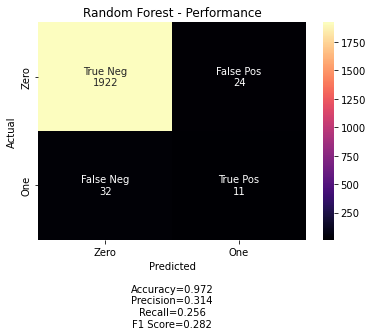

In [ ]:
# Plot Confusion Matrix for Random Forest
model_name = 'Random Forest'
cm = confusion_matrix(y_test, rfc_pred)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, group_names=labels, categories=categories, percent=False)
plt.title(f'{model_name} - Performance')
print()

In [ ]:
y_pred_rfc = rfc.predict_proba(X_test)[:,1]
rfc_fpr, rfc_tpr, threshold = roc_curve(y_test, y_pred_rfc)
auc_rfc = auc(rfc_fpr, rfc_tpr)

print(auc_rfc)

0.9036246086187528


# Conclusion - best model

AUC - All Models

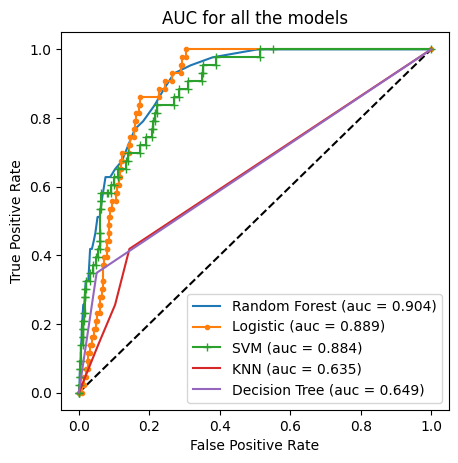

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rfc_fpr, rfc_tpr, linestyle='-', label='Random Forest (auc = %0.3f)' % auc_rfc)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.plot(svm_fpr, svm_tpr, marker='+', label='SVM (auc = %0.3f)' % auc_svm)
plt.plot(knn_fpr, knn_tpr, linestyle='-', label='KNN (auc = %0.3f)' % auc_knn)
plt.plot(DT_fpr, DT_tpr, linestyle='-', label='Decision Tree (auc = %0.3f)' % auc_DT)

plt.title('AUC for all the models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='best')

ROC curve - All Models

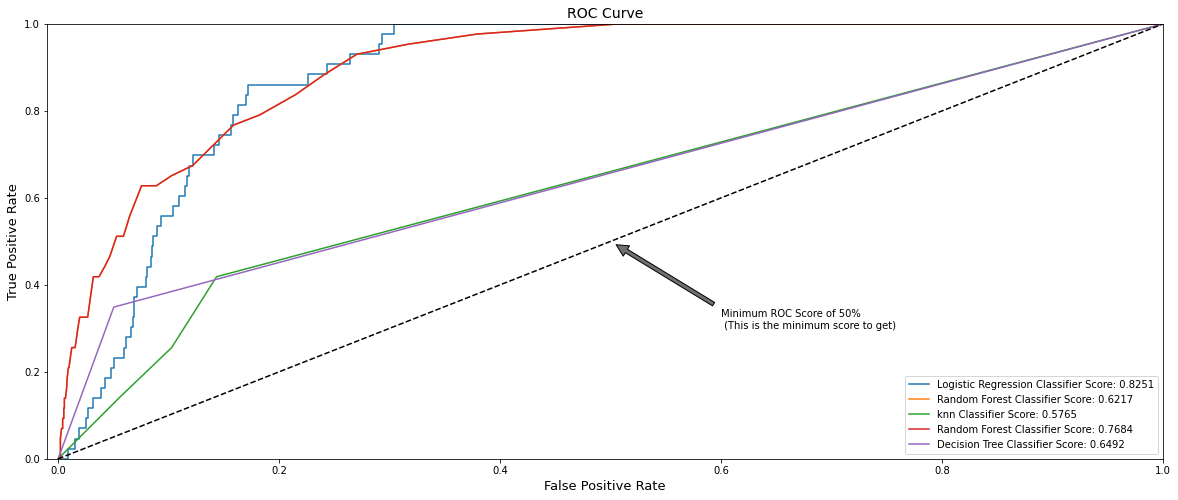

In [ ]:

plt.figure(figsize=(20,8))
plt.title('ROC Curve', fontsize=14)
score_rfc = roc_auc_score(y_test,rfc_pred)
score_logistic = roc_auc_score(y_test,log_predictions)
score_knn = roc_auc_score(y_test,knn_pred>0.5)
score_svm = roc_auc_score(y_test,svm_predictions)
score_DT = roc_auc_score(y_test,pred_DT>0.5)
plt.plot(logistic_fpr, logistic_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(score_logistic))
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier Score: {:.4f}'.format(score_rfc))
plt.plot(knn_fpr, knn_tpr, label='knn Classifier Score: {:.4f}'.format(score_knn))
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier Score: {:.4f}'.format(score_svm))
plt.plot(DT_fpr, DT_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(score_DT))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
            arrowprops=dict(facecolor='#6E726D', shrink=0.05),
            )
plt.legend()
plt.show()

# Test Data Predictions

In [ ]:
## Removing the attributes from test data given
## Using Random Forest to predict the Outcome of Given Test Data 

test_DF1 = test_DF.drop(['Attr2',
 'Attr7',
 'Attr4',
 'Attr11',
 'Attr8',
 'Attr13',
 'Attr14',
 'Attr19',
 'Attr10',
 'Attr16',
 'Attr23',
 'Attr22',
 'Attr31',
 'Attr12',
 'Attr39',
 'Attr30',
 'Attr43',
 'Attr40',
 'Attr32',
 'Attr42',
 'Attr17',
 'Attr38',
 'Attr47',
 'Attr28',
 'Attr53',
 'Attr20',
 'Attr56',
 'Attr57',
 'Attr45',
 'Attr44',
 'Attr33',
 'Attr46',
 'Attr54','ID'], axis =1)
rfc_predictions1 = rfc.predict(test_DF1)



In [ ]:
print("With Random Forest: '\n'", rfc_predictions1)

With Random Forest: '
' [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 

In [ ]:
bankrupt = rfc_predictions1[np.where(rfc_predictions1 == 1)].size
print(bankrupt)
rate_bankrupt = round(bankrupt/len(rfc_predictions1),3)
print("% of Companies that went Bankrupt :", rate_bankrupt*100,"%")

rate_non_bankrupt = round((len(rfc_predictions1)-bankrupt)/len(rfc_predictions1),2)
print("% of Companies that did not went Bankrupt :", rate_non_bankrupt*100,"%")

17
% of Companies that went Bankrupt : 0.3 %
% of Companies that did not went Bankrupt : 100.0 %
